#Description:
In this notebook, we will discover Frequentist approach in A/B testing, explore-exploit dilemma, possible solutions to maximize the


commercial profit by optimizing exploration phase and the Bayesian Approach for A/B testing




#Part 1: Data Preparation

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
import warnings
warnings.filterwarnings('ignore')

In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("osuolaleemmanuel/ad-ab-testing")

print("Path to dataset files:", path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/osuolaleemmanuel/ad-ab-testing/versions/1


In [35]:
df = pd.read_csv("/home/codespace/.cache/kagglehub/datasets/osuolaleemmanuel/ad-ab-testing/versions/1/AdSmartABdata - AdSmartABdata.csv",
                 on_bad_lines="skip")
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


Data description:

* auction_id: the unique id for the instance

* experiment: control/treatment grouping, binary

Note: control group saw a regular advertisement and the treatment group saw SmartAd's interactive advertisement

* date: YYYY-MM-DD

* hour: the hour of the day

* device_make: the name of the device, not much instructive in this dataset

* platform_os: the id of the OS of the device

* browser: the name of the browser the user uses

* yes: 1 if the user chooses “Yes” for the BIO questionnaire

* no: 1 if the user chooses “No” for the BIO questionnaire

In this study, we will assume "no" and "no answer" has the same outcome. Additionally, device_make and platform_os is expected to have minimal effect (would consider clustering is the dataset was larger)

In [36]:
df.drop(columns=['auction_id', 'device_make', 'platform_os', 'no'], inplace=True)
df["experiment"] = df["experiment"].replace('exposed', 'treatment', inplace=True)
df.rename(columns={'yes': 'success'}, inplace=True)

control_mean = df.loc[df['experiment'] == 'control', 'success'].mean()
treatment_mean = df.loc[df['experiment'] == 'treatment', 'success'].mean()

print(f'Dataset info: {df.info()} \n')
print(f'Mean of control group is {control_mean:.3f}, and the treatment group is {treatment_mean:.3f} \n')
print(f'{df.head(5)}')

<class 'pandas.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   experiment  8077 non-null   str  
 1   date        8077 non-null   str  
 2   hour        8077 non-null   int64
 3   browser     8077 non-null   str  
 4   success     8077 non-null   int64
dtypes: int64(2), str(3)
memory usage: 315.6 KB
Dataset info: None 

Mean of control group is 0.065, and the treatment group is 0.077 

  experiment        date  hour                browser  success
0  treatment  2020-07-10     8          Chrome Mobile        0
1  treatment  2020-07-07    10          Chrome Mobile        0
2  treatment  2020-07-05     2  Chrome Mobile WebView        0
3    control  2020-07-03    15               Facebook        0
4    control  2020-07-03    15          Chrome Mobile        0


<Axes: xlabel='hour'>

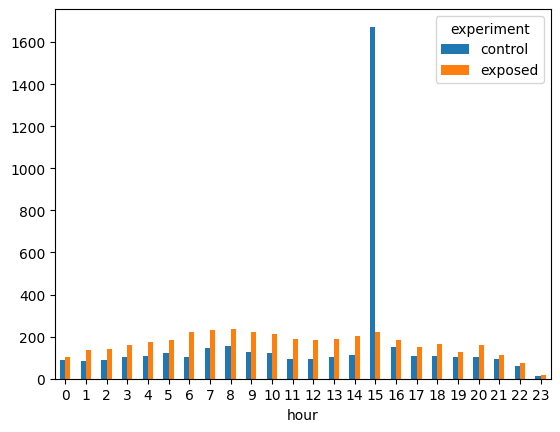

In [23]:
#Checking data point distribution according to the hour of the day
out = pd.crosstab(df['hour'], df['experiment'])
out.plot.bar(rot=0)

There is an unusual control group data points at around 3pm. We need to check whether there is significant difference in success rates at this point. If yes, we need to adjust our dataset.


In [24]:
df_15 = df[df['hour'] == 15]
control_15 = df_15.loc[df_15['experiment'] == 'control', 'success'].mean()
treatment_15 = df_15.loc[df_15['experiment'] == 'treatment', 'success'].mean()

print(f'At 3pm, mean of control group is {control_15:.3f}, and the treatment group is {treatment_15:.3f} \n')


At 3pm, mean of control group is 0.068, and the treatment group is nan 



There is an unusual control-treatment balance at 3pm and the success rates does not similar to average success rates(especially for the treatment group). Further inspection shows that there was an unusual amount of control group subjects on 2020-07-03 at 3pm. Therefore, I will be excluding all datapoints belongs to 2020-07-03.

Note: I assume there is a problem at the given date/time. As the dataset is external, I have no chance of exploring the real reason to decide keep/exclude decision.


In [25]:
df.drop(df[(df['date'] == '2020-07-03') & (df['hour'] == 15)].index, inplace=True)
control_mean = df.loc[df['experiment'] == 'control', 'success'].mean()
treatment_mean = df.loc[df['experiment'] == 'treatment', 'success'].mean()

print(f'Dataset info: {df.info()} \n')
print(f'Mean of control group is {control_mean:.3f}, and the treatment group is {treatment_mean:.3f} \n')

<class 'pandas.DataFrame'>
Index: 6531 entries, 0 to 8076
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   experiment  6531 non-null   str  
 1   date        6531 non-null   str  
 2   hour        6531 non-null   int64
 3   browser     6531 non-null   str  
 4   success     6531 non-null   int64
dtypes: int64(2), str(3)
memory usage: 306.1 KB
Dataset info: None 

Mean of control group is 0.063, and the treatment group is nan 



<Axes: xlabel='browser'>

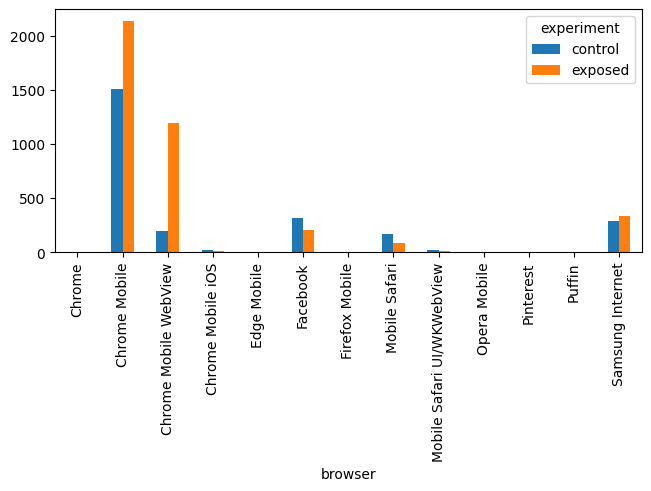

In [26]:
out = pd.crosstab(df['browser'], df['experiment'])
fig, ax = plt.subplots(constrained_layout=True)
out.plot(kind='bar', ax=ax)


In [27]:
df_cmw = df[df['browser'] == "Chrome Mobile WebView"]
control_cmw = df_cmw.loc[df_cmw['experiment'] == 'control', 'success'].mean()
treatment_cmw = df_cmw.loc[df_cmw['experiment'] == 'treatment', 'success'].mean()

print(f'At 3pm, mean of control group is {control_cmw:.3f}, and the treatment group is {treatment_cmw:.3f} \n')

At 3pm, mean of control group is 0.065, and the treatment group is nan 



The overall mean difference between control and test groups are 0.014 and the difference in Chrome Mobile Webview(the most significant difference in control-test group balance) is 0.017. We can assume it does not distort our analysis much. Additionally, we are not seeing datapoints at Chrome browser. We can conclude that all our users are using their mobile devices.

At this point, we can conclude that our dataset is ready for A/B testing. It would be better if we had enough datapoints to cluster customers according to devices.



#Part 2: Frequentist A/B Testing

`This approach is very easy, `


In [28]:
from statsmodels.stats.proportion import proportions_ztest
x_control = df[df['experiment'] == 'control']['success']
x_treatment = df[df['experiment'] == 'treatment']['success']

x_hat_control = x_control.mean()
x_hat_treatment = x_treatment.mean()
print(f'Expected mean of the control group is {x_hat_control:.3f} and expected mean of the treatment group is {x_hat_treatment:.3f}')

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
count_control = len(x_control)
count_treatment = len(x_treatment)
success_control = x_control.sum()
success_treatment = x_treatment.sum()
stat, pval = proportions_ztest([success_control, success_treatment], [count_control, count_treatment])
print(f'p-value of the z-test is {pval:.3f} \n')
print(f'Control ad is shown {count_control} times and SmartAd is shown {count_treatment} times \n')
av_conversion = df['success'].mean()
print(f'Average conversion rate was {av_conversion:.3f} \n')
print(f'Total conversion was {len(df)*av_conversion:.0f}, would have been {len(df)*x_hat_treatment:.0f} if all ads were SmartAd')

p-value of the z-test is 0.036 

Control ad is shown 2530 times and SmartAd is shown 4001 times 

Average conversion rate was 0.072 

Total conversion was 468, would have been 503 if all ads were SmartAd


Assuming our null hypothesis is mean of the control group is the same with the mean of the treatment group, our p-value is 0.036. I believe 0.10 significance level is enough and the default significance level is 0.05 in many analysis; our p-value is lower than both. Therefore, we can reject the null hypothesis.

However, we we got 468 conversion and would have gotten 35 more conversions if we only used SmartAd. Now, we will explore the possibility of getting more conversion while testing our hypothesis.

#Part 3: Explore-Exploit Dilemma and Epsilon-Greedy Algorithm


In the Frequentist approach, we sacrificied an estimated 35 conversion as we did not exploit the best alternative at a given time. It is true that we did not know the true mean, so could not selected the treatment group for all advertisements. However, we could have switched to SmartAd at some point and could show more SmartAd.

First, we need a way to randomly get a datapoint as we will be using online-learning methods. At this point, the purpose of the study is switching from exploring the SmartAd dataset to exploring alternative A/B testing methodologies using simulation, which is powered by the SmartAd dataset.

In [ ]:
class newData:
  def __init__(self, df):
    self.treatment = df[df['experiment'] == 'treatment']
    self.control = df[df['experiment'] == 'control']

  def getData(self, experiment):
    if experiment == 'treatment':
      return self.treatment.sample(n=1, replace=True)
    elif experiment == 'control':
      return self.control.sample(n=1, replace=True)
    else:
      print(f'Wrong experiment parameter')

dataGetter = newData(df)

In [ ]:
#Trying our new class
treatment_data = dataGetter.getData('treatment')
treatment_data

,experiment,date,hour,browser,success
4787,treatment,2020-07-03,12,Chrome Mobile WebView,0


In [ ]:
#Trying the class in large batches
treatment_sim = []
control_sim = []
for _ in range(20000):
  one_treatment = dataGetter.getData('treatment')
  one_control = dataGetter.getData('control')
  treatment_sim.append(one_treatment['success'].values[0])
  control_sim.append(one_control['success'].values[0])
treatment_sim_mean = np.mean(treatment_sim)
control_sim_mean = np.mean(control_sim)
print(f'In the simulation, treatment conversion mean is {treatment_sim_mean:.3f} and control conversion mean is {control_sim_mean:.3f}')

In the simulation, treatment conversion mean is 0.076 and control conversion mean is 0.062


The simulation sampling means are converging to true sample means (of the dataset), so we can conclude that our simulation is working properly.

Now, we can try epsilon-greedy algorithm to get better results.
In this algorithm, we will explore between alternatives with epsilon probability, and select the best alternative we have the remaining times.

Mean estimate for the control group conversion is 0.0610
Mean estimate for the treatment group conversion is 0.0774
The simulation reached 0.0757 conversion
Showed the control ad 5086 times and treatment ad 44916 times


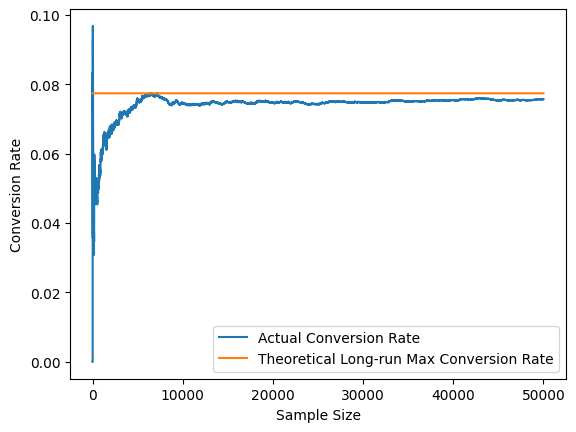

In [ ]:
class AdType():
  def __init__(self):
    self.n = 1
    self.conversion_estimate = 0

  def update(self, success):
    self.conversion_estimate = ((self.n -1) * self.conversion_estimate / self.n) + (success/ self.n)
    self.n += 1

def simulation(df, epsilon, sim_len):
  dataGetter = newData(df)

  groups = [AdType(), AdType()]
  success_list = np.zeros(sim_len)
  times_explored = 0
  times_exploited = 0

  for i in range(sim_len):
      if np.random.random() < epsilon:
        times_explored += 1
        idx = np.random.randint(len(groups))
      else:
        times_exploited += 1
        idx = np.argmax([ad.conversion_estimate for ad in groups])

      if idx == 0:
        success = dataGetter.getData('control')['success'].values[0]
      elif idx == 1:
        success = dataGetter.getData('treatment')['success'].values[0]
      else:
        print(f'There are more than 2 types, check the simulation')

      groups[idx].update(success)
      success_list[i] = success

  print(f'Mean estimate for the control group conversion is {groups[0].conversion_estimate:.4f}')
  print(f'Mean estimate for the treatment group conversion is {groups[1].conversion_estimate:.4f}')

  av_success = np.mean(success_list)
  print(f'The simulation reached {av_success:.4f} conversion')
  print(f'Showed the control ad {groups[0].n} times and treatment ad {groups[1].n} times')

  cumulative_success = np.cumsum(success_list)
  success_rates = cumulative_success / (np.arange(sim_len) + 1)
  plt.plot(success_rates, label="Actual Conversion Rate")
  plt.plot(np.ones(sim_len) * np.max(groups[1].conversion_estimate), label="Theoretical Long-run Max Conversion Rate")
  plt.legend(loc="lower right")
  plt.xlabel("Sample Size")
  plt.ylabel("Conversion Rate")

simulation(df, 0.2, 50000)


Epsilon-greedy algorithm with 0.2 epsilon nearly reached the conversion rate of the treatment group. Also, the algorithm nearly showed SmartAd (treatment) 9x of the control ad. However, we will explore to see if there is a better approach.

#Part 4: Bayesian A/B testing

At the last part, we will see if the Bayesian approach can yield a better approximization to the actual best alternative's conversion rate.

We will be using Thompson Sampling to maximize the expected conversion. Our prior is uninformative Beta distribution (a, b = 1, 1). We will update our parameters according to each new data point.

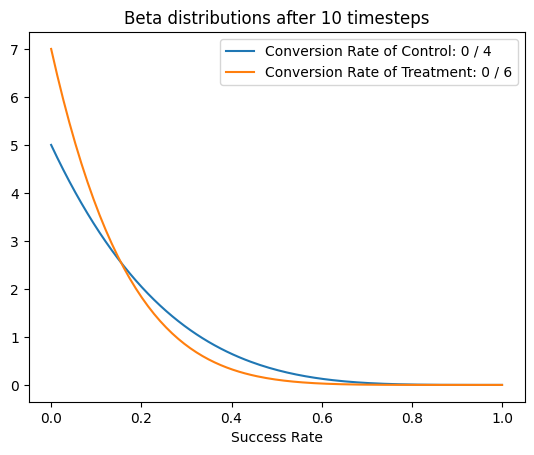

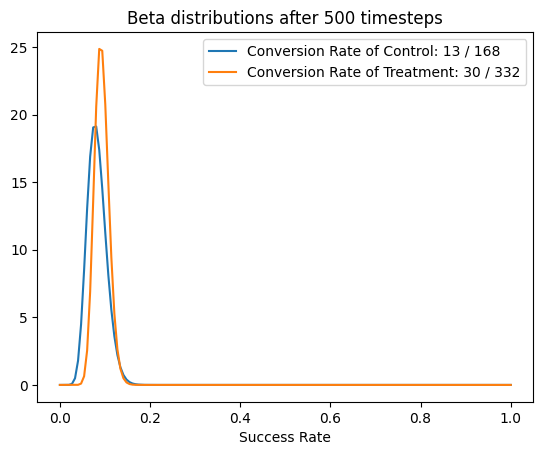

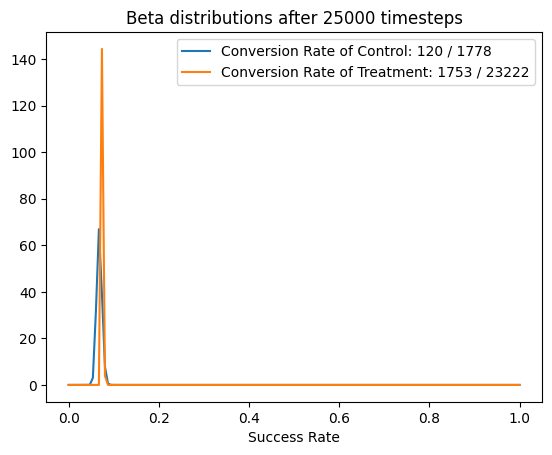

Overall conversion rate: 0.0759


In [ ]:
class AdType():
  def __init__(self):
    self.n = 0
    self.a = 1
    self.b = 1

  def get_sample(self):
    return np.random.beta(self.a, self.b)

  def update(self, success):
    self.n += 1
    self.a += success
    self.b += 1 - success

def plot(groups, timestep):
  x = np.linspace(0, 1, 150)
  y1 = beta.pdf(x, groups[0].a, groups[0].b)
  y2 = beta.pdf(x, groups[1].a, groups[1].b)
  plt.plot(x, y1, label=f'Conversion Rate of Control: {groups[0].a - 1} / {groups[0].n}')
  plt.plot(x, y2, label=f'Conversion Rate of Treatment: {groups[1].a - 1} / {groups[1].n}')
  plt.legend(loc="upper right")
  plt.xlabel("Success Rate")

  plt.title(f"Beta distributions after {timestep} timesteps")
  plt.legend()
  plt.show()

def simulation(df, sim_len):
  dataGetter = newData(df)

  groups = [AdType(), AdType()]
  cut_points = [10,500,25000]
  success_list = np.zeros(sim_len)

  for i in range(sim_len):
    idx = np.argmax([ad.get_sample() for ad in groups])

    if i in cut_points:
      plot(groups, i)

    if idx == 0:
      success = dataGetter.getData('control')['success'].values[0]
    elif idx == 1:
      success = dataGetter.getData('treatment')['success'].values[0]
    else:
      print(f'There are more than 2 types, check the simulation')

    groups[idx].update(success)
    success_list[i] = success
  conversion_rate = np.mean(success_list)
  print(f'Overall conversion rate: {conversion_rate:.4f}')

simulation(df, 50000)

#CONCLUSION

Explore-exploit dilemma is a serious issue in commercial A/B testing setting. Our study shows that a simple epsilon-greedy algorithm is able to solve the issue mostly. More advanced techniques, such as Bayesian methods, can also be employed.